In [23]:
pip install requests pymongo matplotlib pandas wordcloud schedule beautifulsoup4

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import requests
from pymongo import MongoClient
from datetime import datetime
import schedule
import time

# Koneksi ke MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['scansekscrap']
collection = db['berita_kesehatan']

# Buat index unik di "link"
collection.create_index("link", unique=True)

# Daftar endpoint dengan mapping ke kategori
endpoints = {
    "https://api-berita-indonesia.vercel.app/cnn/gayaHidup/": "Gaya Hidup",
    "https://api-berita-indonesia.vercel.app/merdeka/sehat/": "Kesehatan",
    "https://api-berita-indonesia.vercel.app/tribun/kesehatan/": "Kesehatan",
    "https://api-berita-indonesia.vercel.app/antara/lifestyle/": "Gaya Hidup",
    "https://api-berita-indonesia.vercel.app/okezone/lifestyle/": "Gaya Hidup",
    "https://api-berita-indonesia.vercel.app/sindonews/lifestyle/": "Gaya Hidup",
    "https://api-berita-indonesia.vercel.app/tempo/gaya/": "Gaya Hidup"
}

def scrap_dan_simpan():
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] 🚀 Mulai scraping...")

    session = requests.Session()
    total_disimpan = 0

    for endpoint, kategori in endpoints.items():
        try:
            res = session.get(endpoint, timeout=10)
            res.raise_for_status()
            data = res.json()

            if 'data' not in data or 'posts' not in data['data']:
                print(f"⚠️  Struktur data tidak valid dari {endpoint}")
                continue

            for article in data['data']['posts']:
                berita = {
                    "judul": article['title'],
                    "link": article['link'],
                    "thumbnail": article.get('thumbnail', ''),
                    "description": article.get('description', ''),
                    "pubDate": article.get('pubDate', ''),
                    "source": endpoint.split('/')[3],
                    "category": kategori,
                    "tanggal_scrap": datetime.now()
                }

                result = collection.update_one(
                    {"link": berita["link"]},
                    {"$set": berita},
                    upsert=True
                )

                if result.upserted_id:
                    total_disimpan += 1
                    print(f"✅ Baru: {berita['judul']} [{berita['source']}]")
                else:
                    print(f"♻️ Update: {berita['judul']}")

        except Exception as e:
            print(f"❌ Gagal ambil dari {endpoint}: {e}")

    print(f"🟢 Scraping selesai. Total baru disimpan: {total_disimpan}")
    print(f"📦 Total dokumen di DB: {collection.count_documents({})}\n")

# Jadwal scraping tiap 5 menit
schedule.every(1).minutes.do(scrap_dan_simpan)

print("⏱️ Scheduler aktif. Tekan Ctrl+C untuk berhenti.")

while True:
    schedule.run_pending()
    time.sleep(1)


⏱️ Scheduler aktif. Tekan Ctrl+C untuk berhenti.
[2025-05-20 19:34:55] 🚀 Mulai scraping...
✅ Baru: Waspada Gejala Awal Leukemia, Kenali Tanda-Tandanya Sejak Dini [cnn]
♻️ Update: 8 Penyebab Pembuluh Darah Pecah yang Dialami Suami Najwa Shihab
♻️ Update: FOTO: Semarak Festival Sanja Matsuri 2025 Tokyo, Ramai Dihadiri Yakuza
♻️ Update: Ternyata Ini Penyebab Lonjakan Kasus TBC di Indonesia
♻️ Update: Kisah Pulau Aoshima di Jepang, Inspirasi Jakarta Bikin Pulau Kucing
♻️ Update: FOTO: Warna-warni Pameran Bunga Paling Bergengsi di Dunia
♻️ Update: 5 Taman di Jakarta yang Sekarang Buka 24 Jam
♻️ Update: Diidap Joe Biden, Ini Gejala Kanker Prostat yang Wajib Diwaspadai
♻️ Update: 10 Kota di Dunia dengan Pajak Turis Termahal, Ada Rp700 Ribu per Malam
♻️ Update: Rahasia Umur Panjang, Ini Jus Terbaik buat Usia 50-an Menurut Ahli
♻️ Update: 5 Turis Tewas Usai Kapal Dihantam Gelombang Tinggi di Laut Merah
♻️ Update: Belum Coba Wisata Luar Angkasa? Harga Tiketnya Sudah Naik Tahun Depan
♻️ Update: D

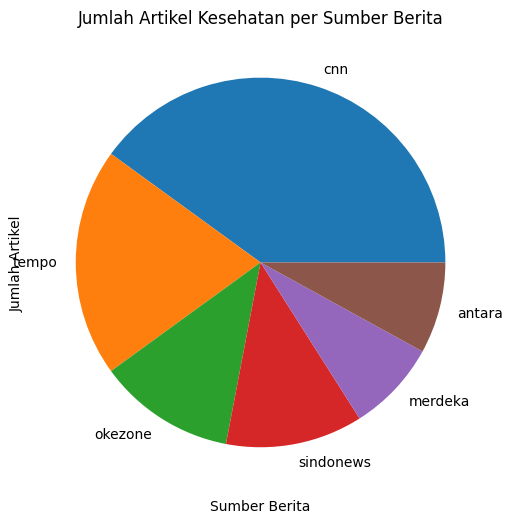

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

data = list(collection.find())
df = pd.DataFrame(data)

df_group = df['source'].value_counts()

df_group.plot(kind='pie', figsize=(10, 6))
plt.xlabel('Sumber Berita')
plt.ylabel('Jumlah Artikel')
plt.title('Jumlah Artikel Kesehatan per Sumber Berita')
plt.xticks(rotation=45)
plt.show()


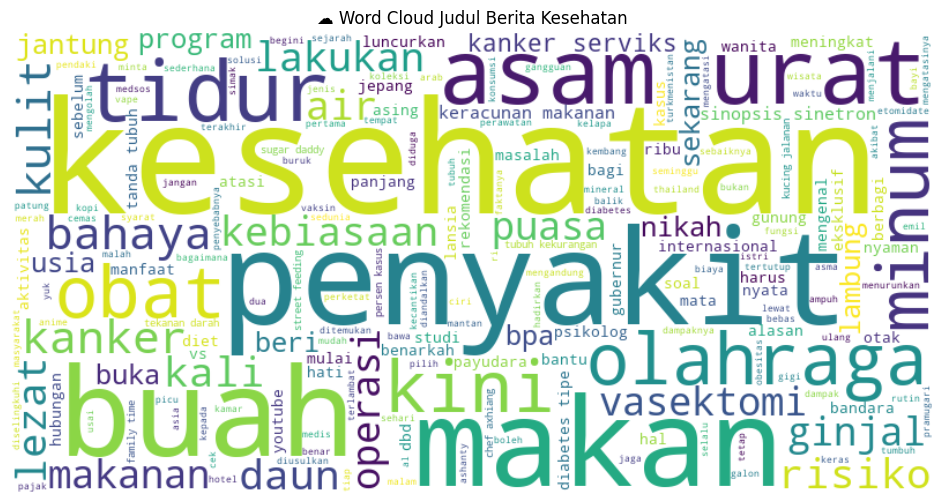

C:\Users\iqbal\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


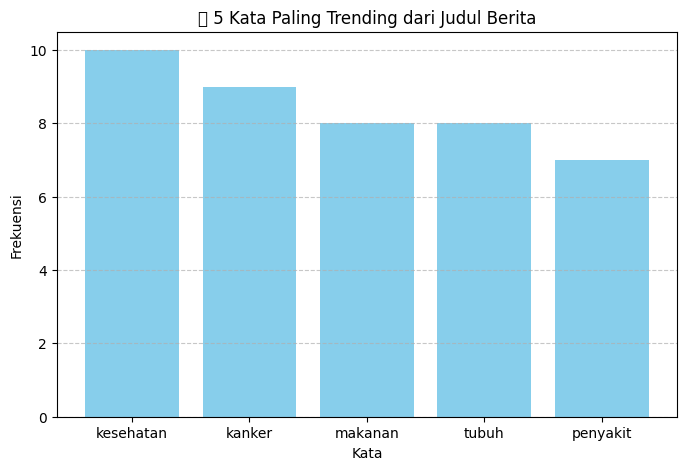

In [22]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import re

# Gabungkan semua judul menjadi teks
text = ' '.join(df['judul'].fillna('').tolist()).lower()

# Buat daftar stopwords tambahan (Indonesia + English)
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'apa', 'cara', 'bikin', 'kenali', 'gejala', 'lagi', 'foto', 'ajak', 'tidak',
    'bareng', 'dalam', 'setelah', 'sering', 'tips', 'kamu', 'kota', 'jam',
    'banyak', 'turis', 'viral', 'potret', 'untuk', 'dari', 'yang', 'dan',
    'dengan', 'pada', 'akan', 'juga', 'saat', 'itu', 'ini', 'sebagai', 'tak',
    'oleh', 'di', 'ke', 'ada', 'karena', 'agar', 'jadi', 'lebih', 'mari', 'anak', 'hari', 'bisa', 'tidak', 'tahun', 'hingga', 'muda', 'tua',
  'robby', 'purba', 'miss', 'dedi', 'mulyadi', 'rcti', 'eps', 'ala', 'lagi',
  'dunia', 'daftar', 'kisah', 'serial', 'series', 'ungkap', 'fakta', 'tapi',
  'mana', 'melihat', 'netizen', 'video', 'ungkap', 'cukup', 'paling', 'langsung',
  'dalam', 'perlu', 'setelah', 'masih', 'muncul', 'banyak', 'indonesia', 'bulan', 'orang', 'sehat', 'diri', 'negara', 'rumah',
  'bayar', 'dokter', 'rambut', 'cantik', 'penumpang', 'pesawat',
  'ayam', 'jakarta', 'bandung', 'saudi', 'china', 'turis',
  'juta', 'meil', 'mei', 'pagi', 'kembali', 'alami', 'selama', 'ikut',
  'perempuan', 'pria', 'beli', 'baru', 'lama', 'cepat', 'terus',
  'guna', 'ikut', 'buat', 'salah', 'cuma', 'ikut', 'terbaik',
  'ikut', 'pentingnya', 'kisah', 'vision', 'langit', 'terjadi',
  'naik', 'cuma', 'saat', 'masa', 'hanya'
])

# Buat Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=custom_stopwords
).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('☁️ Word Cloud Judul Berita Kesehatan')
plt.show()

# Tokenisasi kata, hapus tanda baca, dan filter stopwords
words = re.findall(r'\b[a-zA-Z]{3,}\b', text)
filtered_words = [word for word in words if word not in custom_stopwords]

# Hitung kata trending
counter = Counter(filtered_words)
top_5 = counter.most_common(5)

# Visualisasi bar chart kata trending
if top_5:
    labels, counts = zip(*top_5)
    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color='skyblue')
    plt.title('🔥 5 Kata Paling Trending dari Judul Berita')
    plt.xlabel('Kata')
    plt.ylabel('Frekuensi')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Tidak ada kata yang bisa divisualisasikan.")
